# Example: noisy identity process on two qubits

This example is featured in the paper.


**Contents:**
* [Python initializations](#Python-initializations)
* [Data set-up](#Data-set-up)
* [Bipartite sampling method](#Bipartite-sampling-method)
* [Bipartite sampling method, optimized](#Bipartite-sampling-method,-optimized)
* [Fit with our empirical model \#2](#Fit-with-our-empirical-model-#2)
* [Bipartite sampling method, optimize, entanglement fidelity](#Bipartite-sampling-method,-optimized,-entanglement-fidelity)
* [Bipartite sampling method, optimize, worst-case entanglement fidelity](#Bipartite-sampling-method,-optimized,-worst-case-entanglement-fidelity)
* [Prepare data for channel-space methods](#Prepare-data-for-channel-space-methods)
* [Channel-space method, "$e^{iH}$" variant](#Channel-space-method,-%22$e^{iH}$%22-variant)
* [Channel-space method, "elementary rotations" variant](#Channel-space-method,-%22elementary-rotation%22-variant)
* [Channel-space method, "elementary rotations" variant, entanglement fidelity](#Channel-space-method,-%22elementary-rotation%22-variant,-entanglement-fidelity)
* [Channel-space method, "elementary rotations" variant, worst-case entanglement fidelity](#Channel-space-method,-%22elementary-rotation%22-variant,-worst-case-entanglement-fidelity)
* [Grand comparison plots](#Grand-comparison-plots)


## Python initializations

In [1]:
from __future__ import print_function
import os.path
import sys
import datetime

import numpy as np
import numpy.linalg as npl

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
matplotlib.rc('font', family='Arial')

from IPython.display import display, Markdown, Latex

import dnormtomo.channelspace
import dnormtomo.bistates
import dnormtomo.util

# use this to load pickle files saved with our old python code
sys.modules['pydnorm_util'] = dnormtomo.util
dnormtomo.util._Ns = dnormtomo.util._Store

import qutip

import tomographer
import tomographer.jpyutil
import tomographer.querrorbars
display(Markdown("Using `dnormtomo` **{}** with `tomographer` **{}**"
                 .format(dnormtomo.__version__, tomographer.__version__)))

# to save & load computation results
try:
    import cPickle as pickle
except:
    import pickle

# interact with plots in notebook
%matplotlib notebook

Using `dnormtomo` **0.9** with `tomographer` **v5.3-65-g44f6a8d**

In [2]:
# utilities for storing & loading calculation results
def save_to_cache(cachesuffix, x):
    with open('_CACHE_'+cachesuffix+'.dat', 'wb') as f:
        pickle.dump(x, f, 2)
def load_from_cache(cachesuffix):
    cachefile = '_CACHE_'+cachesuffix+'.dat'
    if not os.path.exists(cachefile):
        return None
    with open(cachefile, 'rb') as f:
        display(Markdown("Loading `{}` from cache".format(cachesuffix)))
        return pickle.load(f)

## Data set-up

In [3]:
#
# number of outcomes per Pauli pairs
#
NumSamplesPerSetting = 500
# Pauli measurement settings on one system
PauliMeasSettings = [
    [
        qutip.Qobj(qutip.tensor(dnormtomo.util.projpauli(i1, s1),
                                dnormtomo.util.projpauli(i2, s2)).data.toarray(),
                   dims=[[4],[4]])
        for s1 in [1, -1]
        for s2 in [1, -1]
    ]
    for i1 in [1, 2, 3]
    for i2 in [1, 2, 3]
]
#display(PauliMeasSettings)

#
# the "real" states & process from which we simulate outcomes
#
sigmareal_X = qutip.Qobj(np.array([[ 0.35, 0.00, 0.04, 0.1j],
                                   [ 0.00, 0.15, 0.05, 0.00],
                                   [ 0.04, 0.05, 0.32, 0.00],
                                   [-0.1j, 0.00, 0.00, 0.18]]), dims=[[4],[4]])
display(Markdown("Eigenvalues of sigmareal_X = $[" + 
                 ",".join("{:.4g}".format(x) for x in npl.eigvalsh(sigmareal_X.data.toarray()))
                 + "]$"))
#display(sigmareal_X.eigenstates())
MaxEntgl_XY = qutip.Qobj(np.array([ [ 1. if i==j else 0. ] for i in range(4) for j in range(4)]),
                         dims=[[4,4],[1,1]])
#display(MaxEntgl_XY.data.toarray())
Ereal_XY = 0.9*MaxEntgl_XY*MaxEntgl_XY.dag() + 0.1*qutip.Qobj(np.identity(16), dims=[[4,4],[4,4]])/4
#display(Ereal_XY.tr())#.data.toarray().diagonal())
#rho_AB = pydnorm_util.process_matrix(sigmareal_X, Ereal_XY)
#display(rho_AB)
#display(rho_AB.data.diagonal())
#display(rho_AB.tr())

def simulate_measurements():
    #
    # Simulate the outcomes
    #
    d = dnormtomo.util.simulate_process_measurements(sigmareal_X, Ereal_XY,
                                                     PauliMeasSettings,
                                                     PauliMeasSettings,
                                                     NumSamplesPerSetting)
    
    return d

#
# Only simulate the measurements once. After that, use the same data when comparing methods!!
#
d = load_from_cache('meas_data')
if d is None:
    d = simulate_measurements()
    save_to_cache('meas_data', d)

display(Markdown("We have **{}** total measurements".format(sum(d.Nm))))

#print(d.__dict__) # prints Emn, Nm ... long outputs!!

Eigenvalues of sigmareal_X = $[0.1294,0.1391,0.3192,0.4124]$

Loading `meas_data` from cache

We have **40500** total measurements

In [4]:
#
# Stuff for the analysis, later
#

def print_report(r):
    display(Markdown("Calculation ran for **{!s} seconds**".format(datetime.timedelta(seconds=r['elapsed_seconds']))))
    display(Markdown("```\n{}\n```".format(r['final_report_runs'])))

def do_analysis(r, name, plots=False, ftox=(0,1), qtyname='diamond distance'):
    final_histogram = r['final_histogram']
    analysis = tomographer.querrorbars.HistogramAnalysis(final_histogram, ftox=ftox)
    fitparams = analysis.printFitParameters()
    analysis.printQuantumErrorBars()
    
    p1 = None
    p2 = None
    
    if plots:
        p1 = analysis.plot(show_plot=False) # linear scale
        p1.ax.set_title("Distribution of the %s: %s"%(qtyname, name))
        p1.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p1.show()

        p2 = analysis.plot(log_scale=True, show_plot=False) # log scale
        p2.ax.set_title("Distribution of the %s: %s"%(qtyname, name))
        p2.ax.set_xlabel('Diamond Norm distance to the identity channel')
        p2.show()
    
    return {'r': r, 'name': name, 'analysis': analysis, 'fitparams': fitparams, 'p1': p1, 'p2': p2}


## Bipartite sampling method

In [5]:
r_naive = load_from_cache('r_naive')
if r_naive is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_naive = dnormtomo.bistates.run(
            dimX=4, dimY=4, Emn=d.Emn, Nm=np.array(d.Nm),
            hist_params=tomographer.UniformBinsHistogramParams(0.1, 0.3, 100),
            mhrw_params=tomographer.MHRWParams(0.001, 1000, 2048, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            )
        prg.displayFinalInfo(r_naive['final_report_runs'])
    save_to_cache('r_naive', r_naive)

print_report(r_naive)

Loading `r_naive` from cache

Calculation ran for **1:24:43.064386 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.001
	# iter. / sweep = 1000
	# therm. sweeps = 2048
	# run sweeps    = 32768
#0: 0.1|       ....-+x###%o+-.......                      |0.3                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0.1|       ....-+x###%o+-........ .                   |0.3                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.1|       ....-+x###%o+-........                     |0.3                 [accept ratio = 0.30]
    error bars: 96 converged / 4 maybe (4 isolated) / 0 not converged
#3: 0.1|       ....-+x###%o+-.......                      |0.3                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#4: 0.1|      .....-+x###%o+-........                     |0.3                 [accept ratio = 0.30]
    error bars: 97 converged / 3 maybe (3 isolated) / 0 not converged
#5: 0.1|       ....-+x###%o+-........                     |0.3                 [accept ratio = 0.30]
    error bars: 97 converged / 3 maybe (3 isolated) / 0 not converged
#6: 0.1|      .....-+x###%o+-.........                    |0.3                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#7: 0.1|       ....-+x###%o+-........                     |0.3                 [accept ratio = 0.30]
    error bars: 100 converged / 0 maybe (0 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 3.68652e-07
          a1 = 1591.46
           m = 260.276
           c = 735.226
Quantum Error Bars:
          f0 = 0.1635
       Delta = 0.01434
       gamma = 0.0004189



<IPython.core.display.Javascript object>


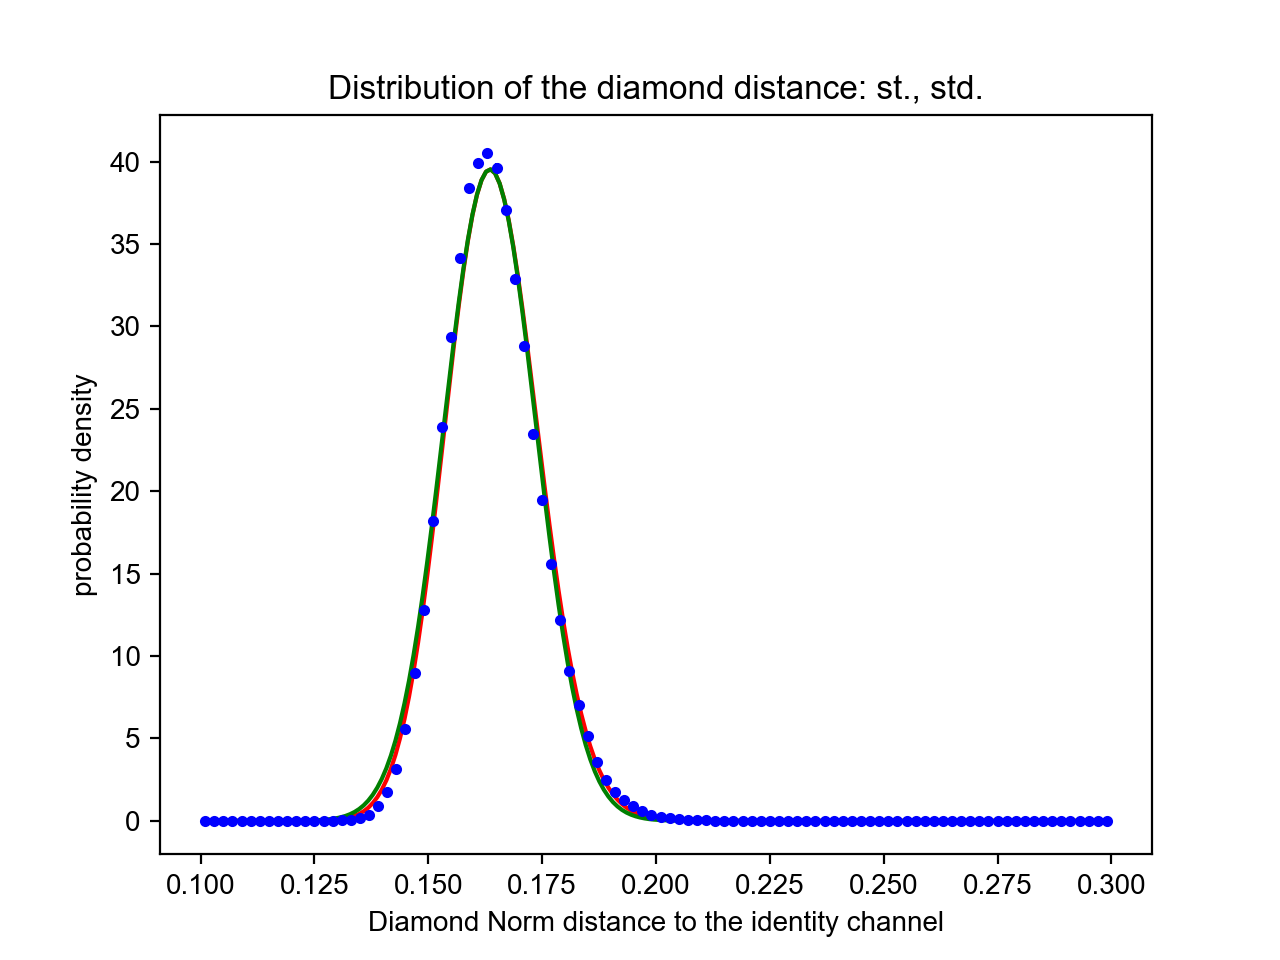

<IPython.core.display.Javascript object>


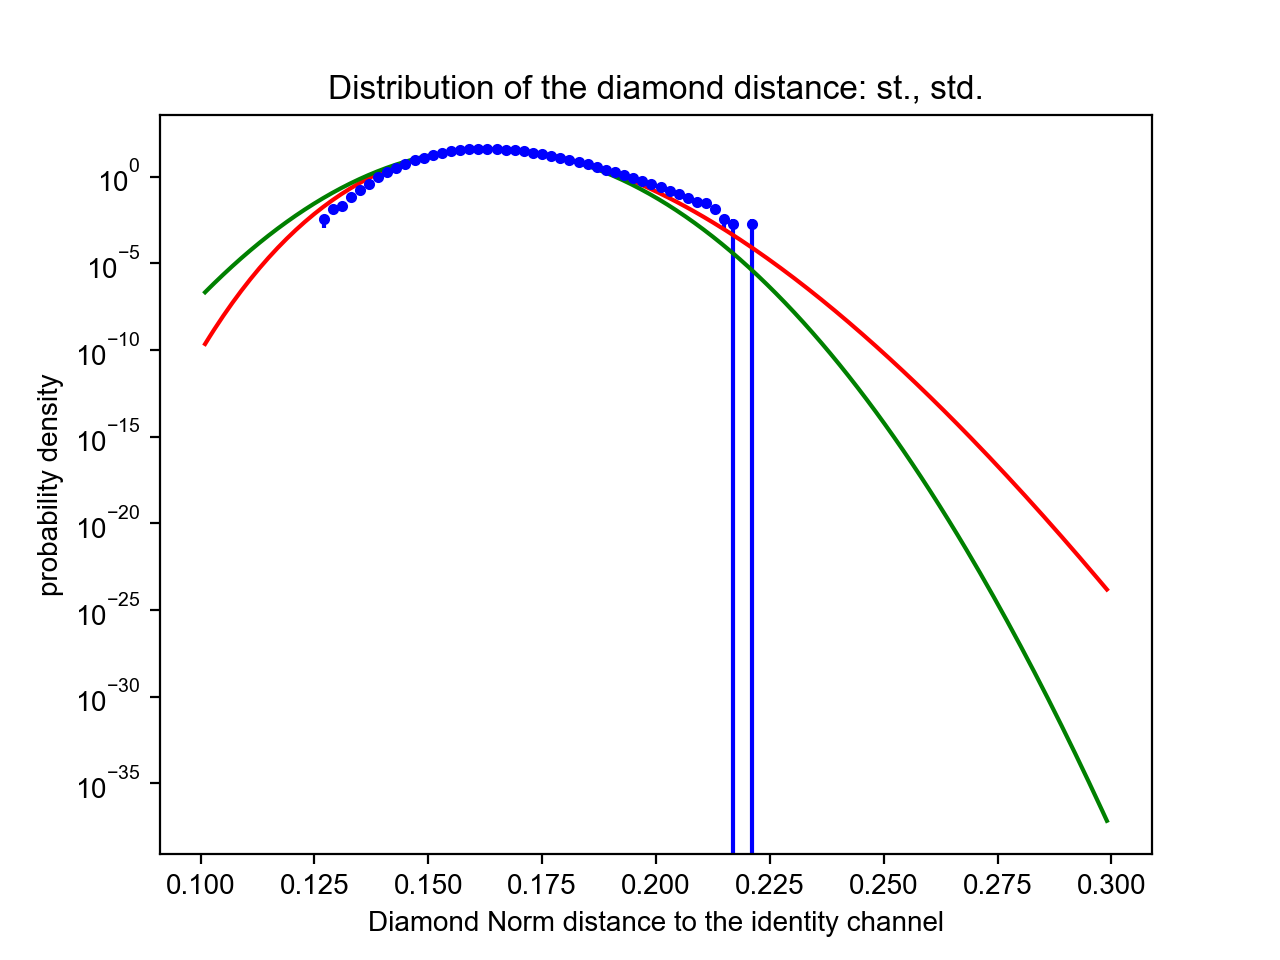

In [8]:
a_naive = do_analysis(r_naive, 'st., std.', plots=True)

## Bipartite sampling method, optimized

In [7]:
r_naiveopt = load_from_cache('r_naiveopt')
if r_naiveopt is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_naiveopt = dnormtomo.bistates.run(
            dimX=4, dimY=4, Emn=d.Emn, Nm=np.array(d.Nm),
            hist_params=tomographer.UniformBinsHistogramParams(0.1, 0.3, 100),
            mhrw_params=tomographer.MHRWParams(0.001, 4000, 8192, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            jumps_method='light',
            )
        prg.displayFinalInfo(r_naiveopt['final_report_runs'])
    save_to_cache('r_naiveopt', r_naiveopt)

print_report(r_naiveopt)

Loading `r_naiveopt` from cache

Calculation ran for **0:17:14.461779 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.001
	# iter. / sweep = 4000
	# therm. sweeps = 8192
	# run sweeps    = 32768
#0: 0.1|       ....-+x###%o+-....... .                    |0.3                 [accept ratio = 0.31]
    error bars: 93 converged / 7 maybe (1 isolated) / 0 not converged
#1: 0.1|       ....-+x###%o+-........                     |0.3                 [accept ratio = 0.31]
    error bars: 91 converged / 9 maybe (3 isolated) / 0 not converged
#2: 0.1|       ....-+x###%o+-........                     |0.3                 [accept ratio = 0.31]
    error bars: 87 converged / 11 maybe (2 isolated) / 2 not converged
#3: 0.1|       ....-+x###%o+-.........                    |0.3                 [accept ratio = 0.31]
    error bars: 86 converged / 11 maybe (3 isolated) / 3 not converged
#4: 0.1|       ....-+x###%o+-........                     |0.3                 [accept ratio = 0.29]
    error bars: 88 converged / 10 maybe (4 isolated) / 2 not converged
#5: 0.1|       ....-+x###%o+-.......                      |0.3                 [accept ratio = 0.29]
    error bars: 86 converged / 10 maybe (2 isolated) / 4 not converged
#6: 0.1|       ....-+x###%o+-..........                   |0.3                 [accept ratio = 0.31]
    error bars: 90 converged / 9 maybe (1 isolated) / 1 not converged
#7: 0.1|      .....-+x###%o+-........                     |0.3                 [accept ratio = 0.31]
    error bars: 93 converged / 7 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 1.2059e-13
          a1 = 1570.24
           m = 256.601
           c = 725.098
Quantum Error Bars:
          f0 = 0.1634
       Delta = 0.01443
       gamma = 0.0004246



<IPython.core.display.Javascript object>


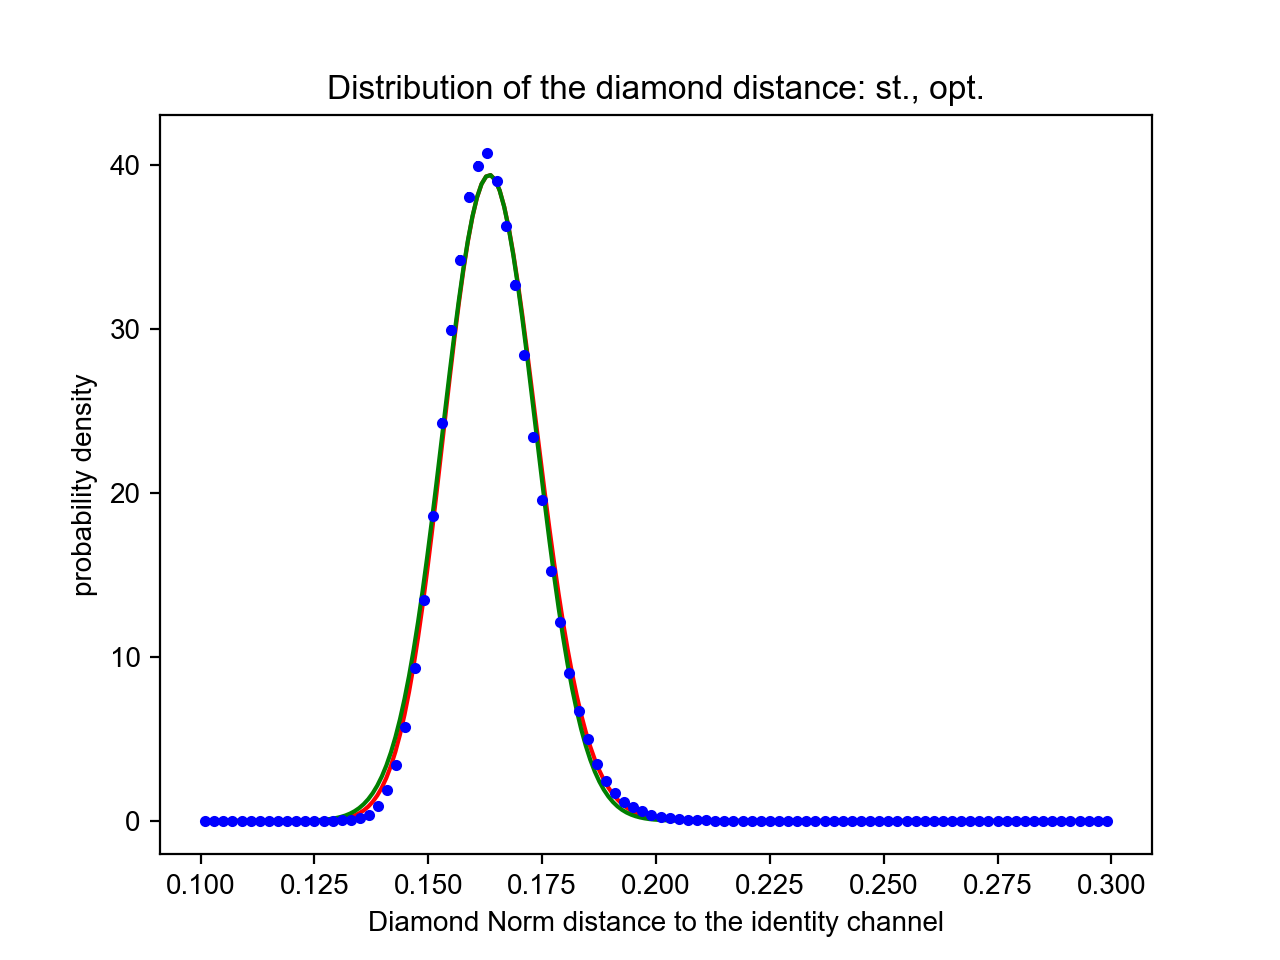

<IPython.core.display.Javascript object>


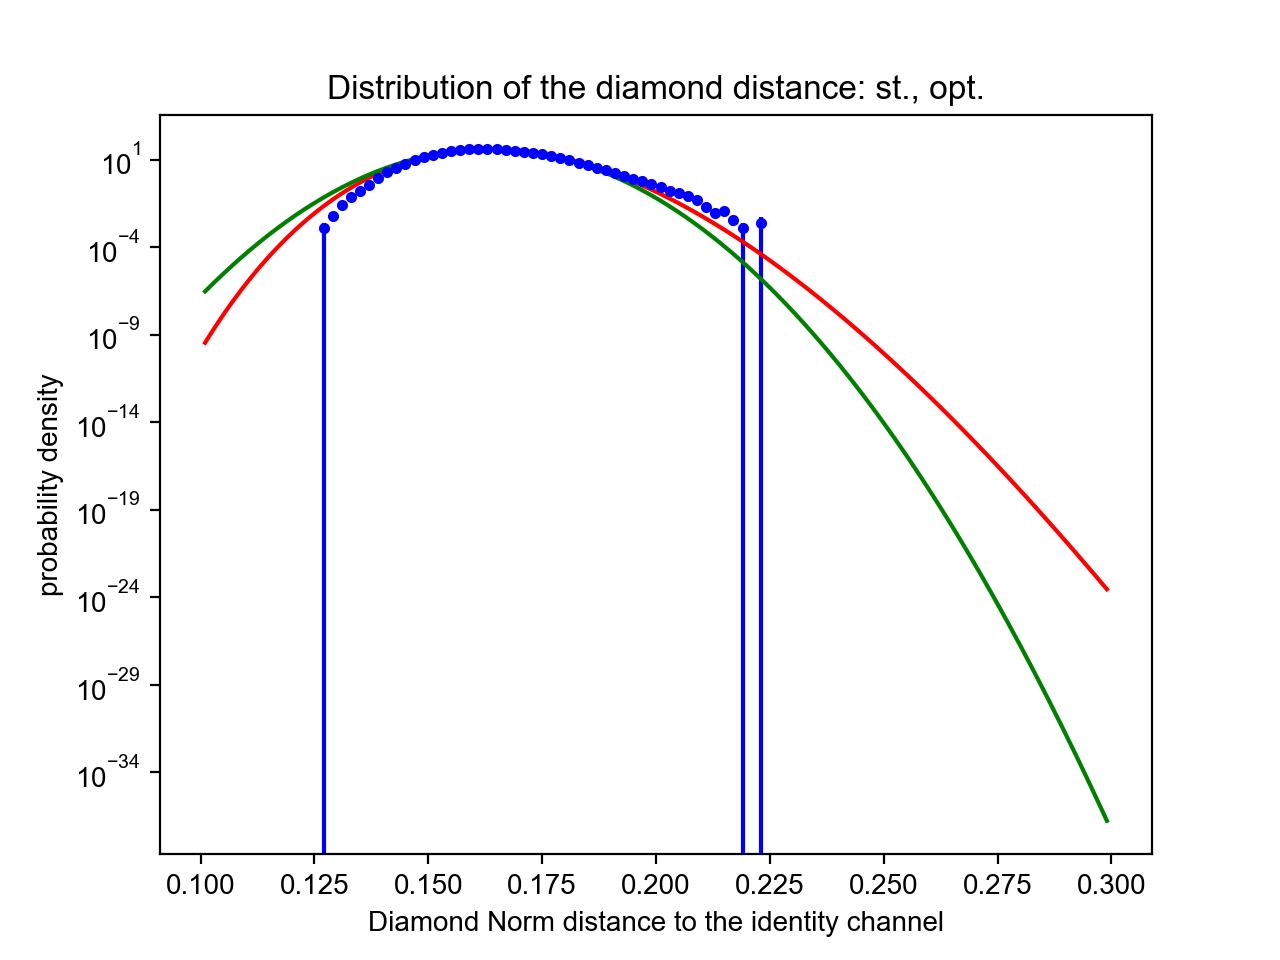

In [9]:
a_naiveopt = do_analysis(r_naiveopt, 'st., opt.', plots=True)

## Fit with our empirical model \#2

Fit parameters:
          a2 = 0.0167741
          a1 = 316.436
           m = 0.0524951
           p = 8.86502
           c = 65.5772


<IPython.core.display.Javascript object>


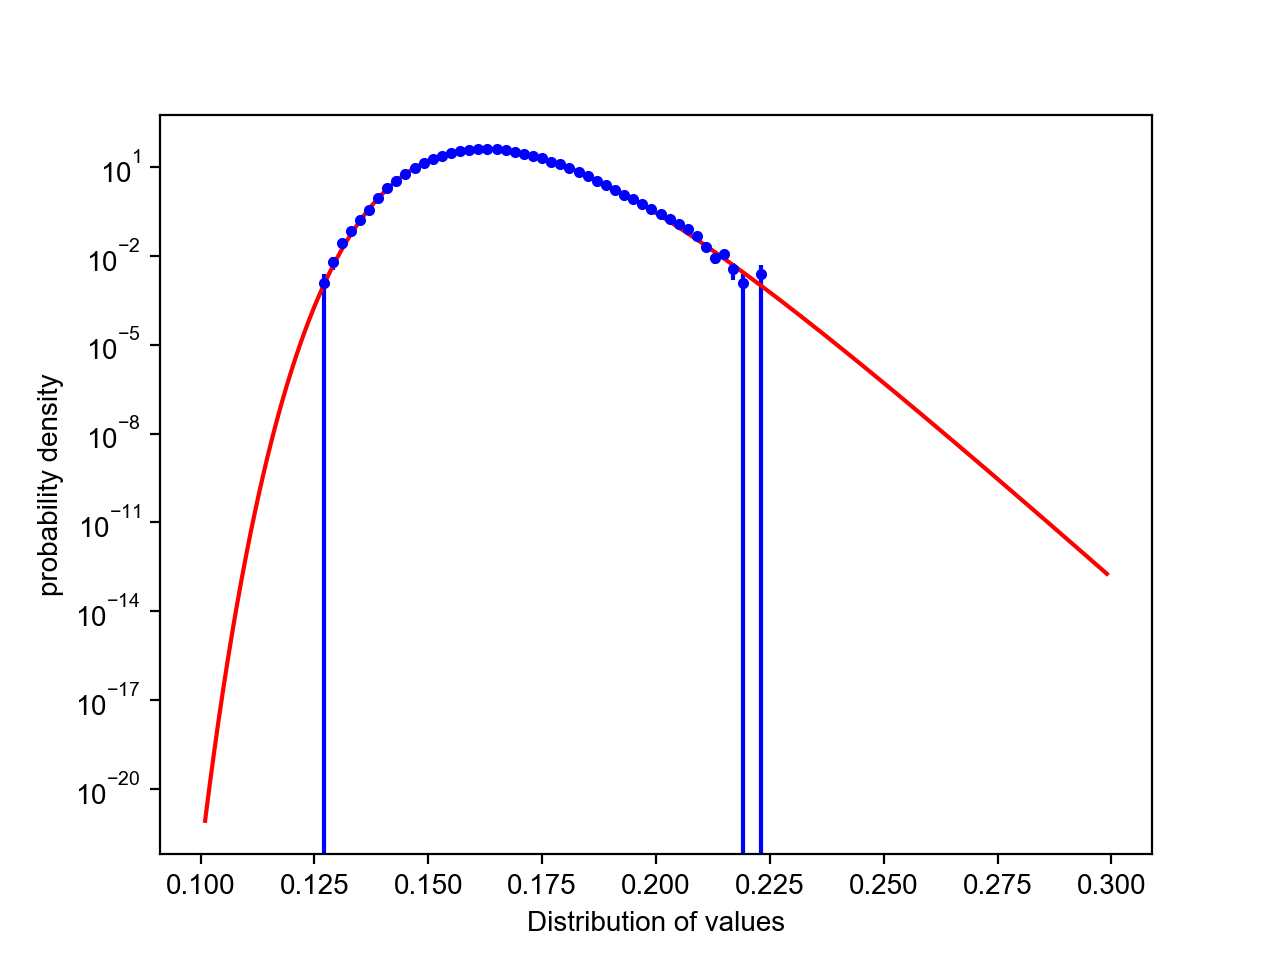

In [10]:
def fit_fn_test(x, a2, a1, m, p, c):
    return -a2* np.square(x) - a1*x - m*np.power(-np.log(x),p) + c
    
a = tomographer.querrorbars.HistogramAnalysis(
    r_naiveopt['final_histogram'], fit_fn=fit_fn_test, bounds=((0,-np.inf,0,0,-np.inf), np.inf)
)
a.printFitParameters()
a.plot(plot_deskewed_gaussian=False, log_scale=True)

## Bipartite sampling method, optimized, entanglement fidelity

In [11]:
r_Fe_naiveopt = load_from_cache('r_Fe_naiveopt')
if r_Fe_naiveopt is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_Fe_naiveopt = dnormtomo.bistates.run(
            dimX=4, dimY=4, Emn=d.Emn, Nm=np.array(d.Nm),
            fig_of_merit='entanglement-fidelity',
            hist_params=tomographer.UniformBinsHistogramParams(0.8, 0.9, 100),
            mhrw_params=tomographer.MHRWParams(0.001, 4000, 8192, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            jumps_method='light',
            )
        prg.displayFinalInfo(r_Fe_naiveopt['final_report_runs'])
    save_to_cache('r_Fe_naiveopt', r_Fe_naiveopt)

print_report(r_Fe_naiveopt)

Loading `r_Fe_naiveopt` from cache

Calculation ran for **0:05:52.717475 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.001
	# iter. / sweep = 4000
	# therm. sweeps = 8192
	# run sweeps    = 32768
#0: 0.8|                      .......-+o%##%x+-......     |0.9                 [accept ratio = 0.31]
    error bars: 92 converged / 8 maybe (2 isolated) / 0 not converged
#1: 0.8|                        .....-+o%##%x+-....       |0.9                 [accept ratio = 0.29]
    error bars: 89 converged / 10 maybe (1 isolated) / 1 not converged
#2: 0.8|                        ......+o%##%x+-....       |0.9                 [accept ratio = 0.32]
    error bars: 96 converged / 3 maybe (1 isolated) / 1 not converged
#3: 0.8|                        .....-+o%##%o+-.....      |0.9                 [accept ratio = 0.31]
    error bars: 96 converged / 3 maybe (1 isolated) / 1 not converged
#4: 0.8|                        ......-o%###x+-......     |0.9                 [accept ratio = 0.31]
    error bars: 89 converged / 8 maybe (2 isolated) / 3 not converged
#5: 0.8|                       ......-+o%##%x+-.....      |0.9                 [accept ratio = 0.29]
    error bars: 88 converged / 11 maybe (3 isolated) / 1 not converged
#6: 0.8|                        ......+o%##%x+-.....      |0.9                 [accept ratio = 0.29]
    error bars: 87 converged / 13 maybe (3 isolated) / 0 not converged
#7: 0.8|                        ......+o%##%x+-.....      |0.9                 [accept ratio = 0.31]
    error bars: 95 converged / 5 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 6040.58
          a1 = 3026.24
           m = 608.05
           c = 1740.45
Quantum Error Bars:
          f0 = 0.8683
       Delta = 0.006513
       gamma = 7.987e-05



<IPython.core.display.Javascript object>


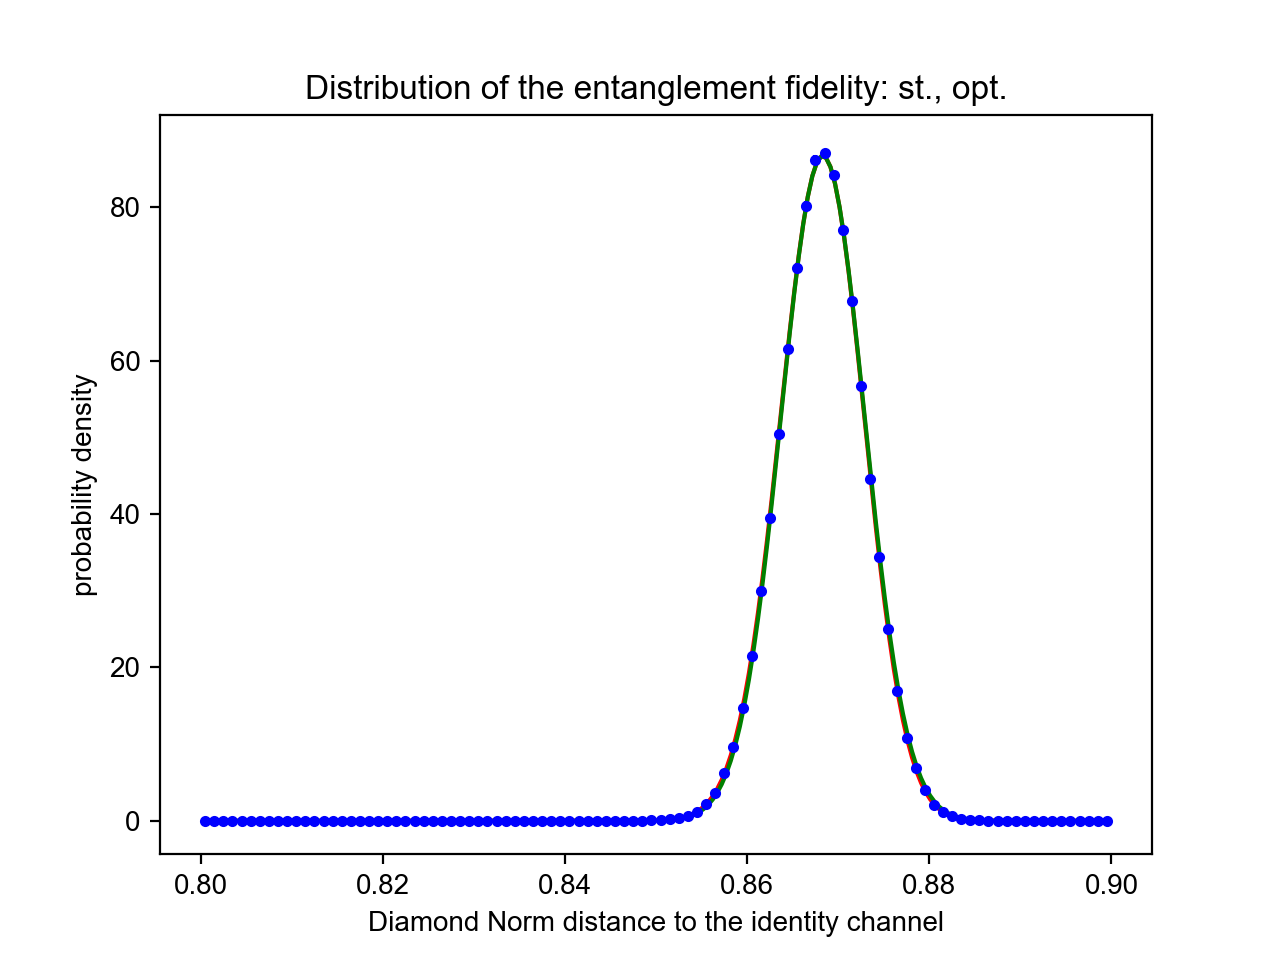

<IPython.core.display.Javascript object>


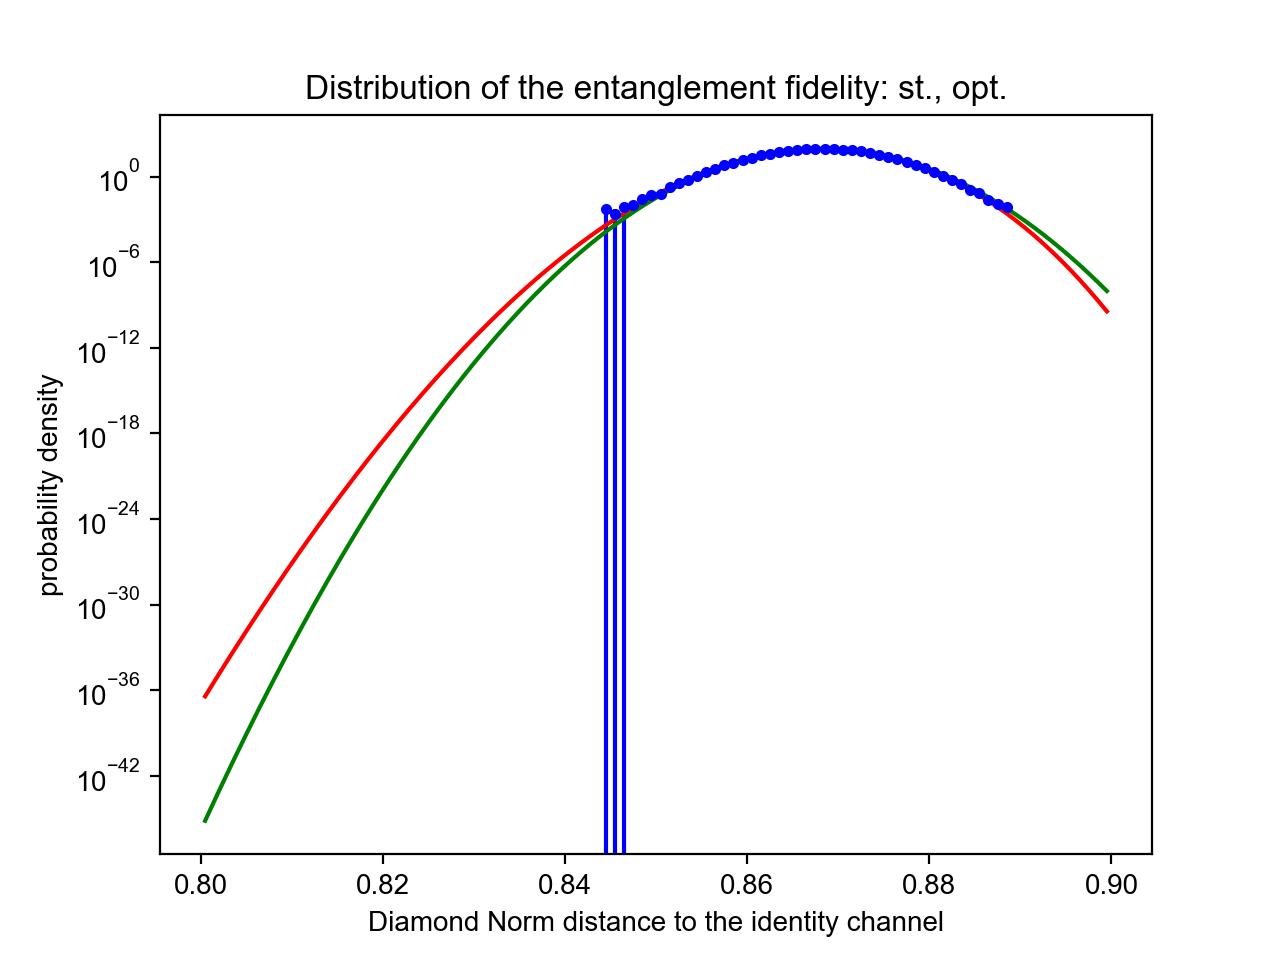

In [12]:
a_Fe_naiveopt = do_analysis(r_Fe_naiveopt, 'st., opt.', plots=True,
                            qtyname='entanglement fidelity', ftox=(1,-1))

## Bipartite sampling method, optimized, worst-case entanglement fidelity

In [13]:
r_wFe_naiveopt = load_from_cache('r_wFe_naiveopt')
if r_wFe_naiveopt is None:
    # perform calculation 
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_wFe_naiveopt = dnormtomo.bistates.run(
            dimX=4, dimY=4, Emn=d.Emn, Nm=np.array(d.Nm),
            fig_of_merit='worst-entanglement-fidelity',
            hist_params=tomographer.UniformBinsHistogramParams(0.75, 0.9, 150),
            mhrw_params=tomographer.MHRWParams(0.001, 4000, 8192, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            jumps_method='light',
            )
        prg.displayFinalInfo(r_Fe_naiveopt['final_report_runs'])
    save_to_cache('r_wFe_naiveopt', r_wFe_naiveopt)

print_report(r_wFe_naiveopt)

Loading `r_wFe_naiveopt` from cache

Calculation ran for **1:07:36.902520 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.001
	# iter. / sweep = 4000
	# therm. sweeps = 8192
	# run sweeps    = 32768
#0: 0.75|          ..............--+x%####%o+-....         |0.9                [accept ratio = 0.31]
    error bars: 141 converged / 9 maybe (5 isolated) / 0 not converged
#1: 0.75|             . .........--+o%####%o+-......       |0.9                [accept ratio = 0.29]
    error bars: 146 converged / 4 maybe (4 isolated) / 0 not converged
#2: 0.75|              ..........-+ox%####%o+-....         |0.9                [accept ratio = 0.29]
    error bars: 137 converged / 13 maybe (3 isolated) / 0 not converged
#3: 0.75|            ............--+x%####%o+-......       |0.9                [accept ratio = 0.31]
    error bars: 142 converged / 8 maybe (8 isolated) / 0 not converged
#4: 0.75|             ...........--+x%####%o+-.....        |0.9                [accept ratio = 0.31]
    error bars: 136 converged / 13 maybe (7 isolated) / 1 not converged
#5: 0.75|          .. ...........-+ox%####%o+-....         |0.9                [accept ratio = 0.32]
    error bars: 143 converged / 7 maybe (3 isolated) / 0 not converged
#6: 0.75|             ...........--+ox####xo+-......       |0.9                [accept ratio = 0.31]
    error bars: 140 converged / 10 maybe (6 isolated) / 0 not converged
#7: 0.75|             ...........-+ox%####%o+-.....        |0.9                [accept ratio = 0.29]
    error bars: 131 converged / 18 maybe (7 isolated) / 1 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 9.9086e-15
          a1 = 1511.67
           m = 238.424
           c = 682.447
Quantum Error Bars:
          f0 = 0.8423
       Delta = 0.01445
       gamma = 0.000441



<IPython.core.display.Javascript object>


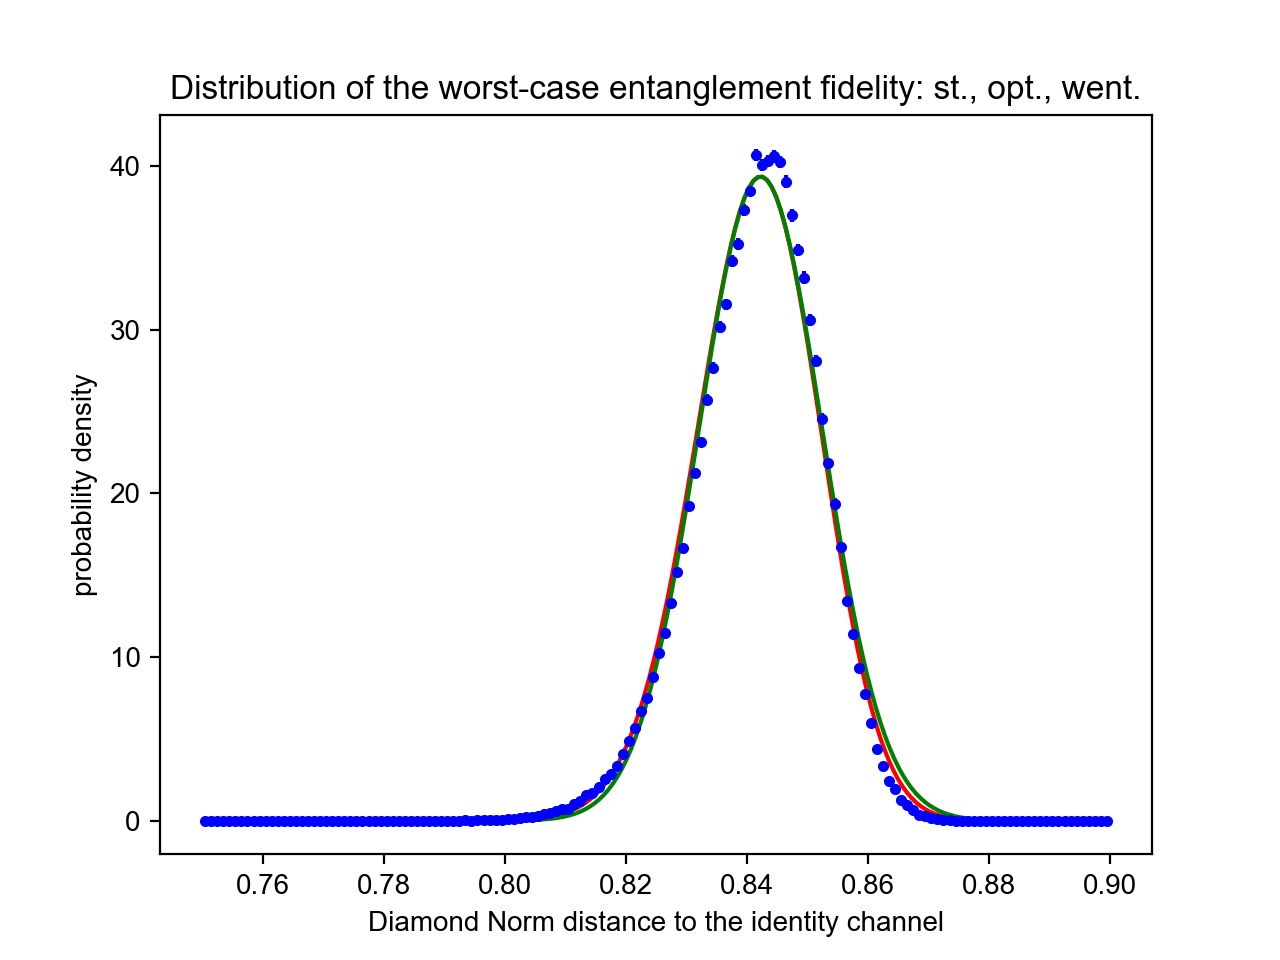

<IPython.core.display.Javascript object>


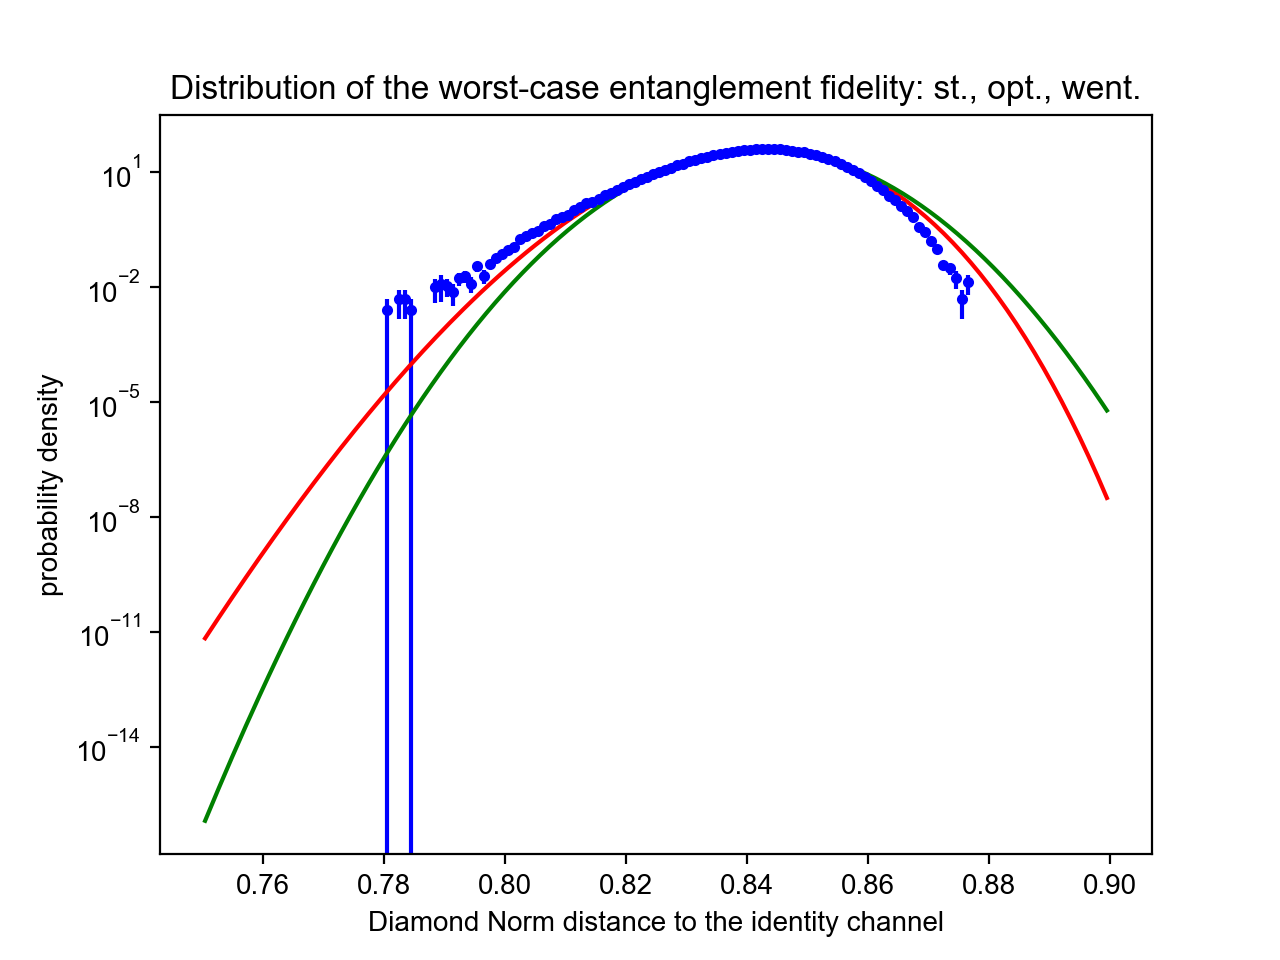

In [14]:
a_wFe_naiveopt = do_analysis(r_wFe_naiveopt, 'st., opt., went.', plots=True,
                             qtyname='worst-case entanglement fidelity', ftox=(1,-1))

## Prepare data for channel-space methods

In [15]:
# we need to encode the input state in the POVM effects

sigmareal_X_sqrtm_eyeY = np.kron(sigmareal_X.sqrtm().data.toarray(), np.eye(4))
Emn_for_channelspace = [
    np.dot(np.dot(sigmareal_X_sqrtm_eyeY, E), sigmareal_X_sqrtm_eyeY)
    for E in d.Emn
]

## Channel-space method, "$e^{iH}$" variant

In [16]:
r_eiH = load_from_cache('r_eiH')
if r_eiH is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_eiH = dnormtomo.channelspace.run(
            dimX=4, dimY=4, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            hist_params=tomographer.UniformBinsHistogramParams(0.1, 0.2, 100),
            channel_walker_jump_mode=pydnormchannelspace.RandHermExp,
            mhrw_params=tomographer.MHRWParams(0.001, 1000, 4096, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            ctrl_converged_params={'enabled':False},
            )
        prg.displayFinalInfo(r_eiH['final_report_runs'])
    save_to_cache('r_eiH', r_eiH)
print_report(r_eiH)

Loading `r_eiH` from cache

Calculation ran for **14:56:06.206485 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.001
	# iter. / sweep = 1000
	# therm. sweeps = 4096
	# run sweeps    = 32768
#0: 0.1|         .......-+o%####%xo+--...........         |0.2                 [accept ratio = 0.31]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#1: 0.1|          ......-+o%%###%xo+--..........          |0.2                 [accept ratio = 0.31]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.1|          ......-+o%####%xo+--..............      |0.2                 [accept ratio = 0.31]
    error bars: 100 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0.1|         .......-+o%####%xo+--.............       |0.2                 [accept ratio = 0.31]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
#4: 0.1|          ......-+o%####%xo+--......... . .       |0.2                 [accept ratio = 0.31]
    error bars: 96 converged / 4 maybe (4 isolated) / 0 not converged
#5: 0.1|         .......-+x%####%xo+--...........   .     |0.2                 [accept ratio = 0.31]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
#6: 0.1|         .......-+o%####%xo+--.............       |0.2                 [accept ratio = 0.31]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#7: 0.1|         .......-+o%#####xo+--............        |0.2                 [accept ratio = 0.31]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

In [17]:
a_eiH = do_analysis(r_eiH, 'ch., eiH')

Fit parameters:
          a2 = 1.60136e-13
          a1 = 2666.08
           m = 386.433
           c = 1136.79
Quantum Error Bars:
          f0 = 0.1449
       Delta = 0.01043
       gamma = 0.0002501



## Channel-space method, "elementary-rotation" variant

In [18]:
r_elr = load_from_cache('r_elr')
if r_elr is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_elr = dnormtomo.channelspace.run(
            dimX=4, dimY=4, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            hist_params=tomographer.UniformBinsHistogramParams(0.1, 0.2, 100),
            channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
            mhrw_params=tomographer.MHRWParams(0.005, 500, 4096, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            )
        prg.displayFinalInfo(r_elr['final_report_runs'])
    save_to_cache('r_elr', r_elr)
print_report(r_elr)

Loading `r_elr` from cache

Calculation ran for **1:41:36.291075 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.005
	# iter. / sweep = 500
	# therm. sweeps = 4096
	# run sweeps    = 32768
#0: 0.1|          ......-+o%####%xo+--......... .         |0.2                 [accept ratio = 0.30]
    error bars: 96 converged / 3 maybe (3 isolated) / 1 not converged
#1: 0.1|          ......-+x%#####xo++-...........         |0.2                 [accept ratio = 0.29]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#2: 0.1|          ......-+x%####%xo++-......... .         |0.2                 [accept ratio = 0.30]
    error bars: 100 converged / 0 maybe (0 isolated) / 0 not converged
#3: 0.1|          ......-+x%####%xo+--.......... ..       |0.2                 [accept ratio = 0.30]
    error bars: 97 converged / 3 maybe (3 isolated) / 0 not converged
#4: 0.1|        ........-+o%####%xo+--.......... .        |0.2                 [accept ratio = 0.30]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
#5: 0.1|         .......-+o%#####xo+--..........          |0.2                 [accept ratio = 0.30]
    error bars: 96 converged / 3 maybe (3 isolated) / 1 not converged
#6: 0.1|         .......-+o%####%xo+--............        |0.2                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#7: 0.1|         .......-+x%####%xo+--........... .       |0.2                 [accept ratio = 0.30]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

In [19]:
a_elr = do_analysis(r_elr, 'ch., elr.')

Fit parameters:
          a2 = 1.16189e-07
          a1 = 2642.59
           m = 383.192
           c = 1127.12
Quantum Error Bars:
          f0 = 0.145
       Delta = 0.01048
       gamma = 0.0002523



## Channel-space method, "elementary-rotation" variant, entanglement fidelity

In [20]:
r_Fe_elr = load_from_cache('r_Fe_elr')
if r_Fe_elr is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_Fe_elr = dnormtomo.channelspace.run(
            dimX=4, dimY=4, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            fig_of_merit='entanglement-fidelity',
            hist_params=tomographer.UniformBinsHistogramParams(0.8, 0.9, 100),
            channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
            mhrw_params=tomographer.MHRWParams(0.005, 500, 4096, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            )
        prg.displayFinalInfo(r_Fe_elr['final_report_runs'])
    save_to_cache('r_Fe_elr', r_Fe_elr)
print_report(r_Fe_elr)

Loading `r_Fe_elr` from cache

Calculation ran for **1:44:28.662521 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.005
	# iter. / sweep = 500
	# therm. sweeps = 4096
	# run sweeps    = 32768
#0: 0.8|                             .....-+x###x+-....   |0.9                 [accept ratio = 0.30]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
#1: 0.8|                             .....-+x###x+-....   |0.9                 [accept ratio = 0.30]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
#2: 0.8|                             .....-+x###x+-.....  |0.9                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#3: 0.8|                             .....-+x###x+-.....  |0.9                 [accept ratio = 0.30]
    error bars: 98 converged / 2 maybe (2 isolated) / 0 not converged
#4: 0.8|                              ....-+x###x+-....   |0.9                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#5: 0.8|                            ......-+x###x+-.... . |0.9                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
#6: 0.8|                           . .....-+x%##x+-.....  |0.9                 [accept ratio = 0.29]
    error bars: 100 converged / 0 maybe (0 isolated) / 0 not converged
#7: 0.8|                             .....-+x###x+-....   |0.9                 [accept ratio = 0.30]
    error bars: 99 converged / 1 maybe (1 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 153.846
          a1 = 6440.22
           m = 795.809
           c = 2466.67
Quantum Error Bars:
          f0 = 0.8772
       Delta = 0.006141
       gamma = 0.0001017



<IPython.core.display.Javascript object>


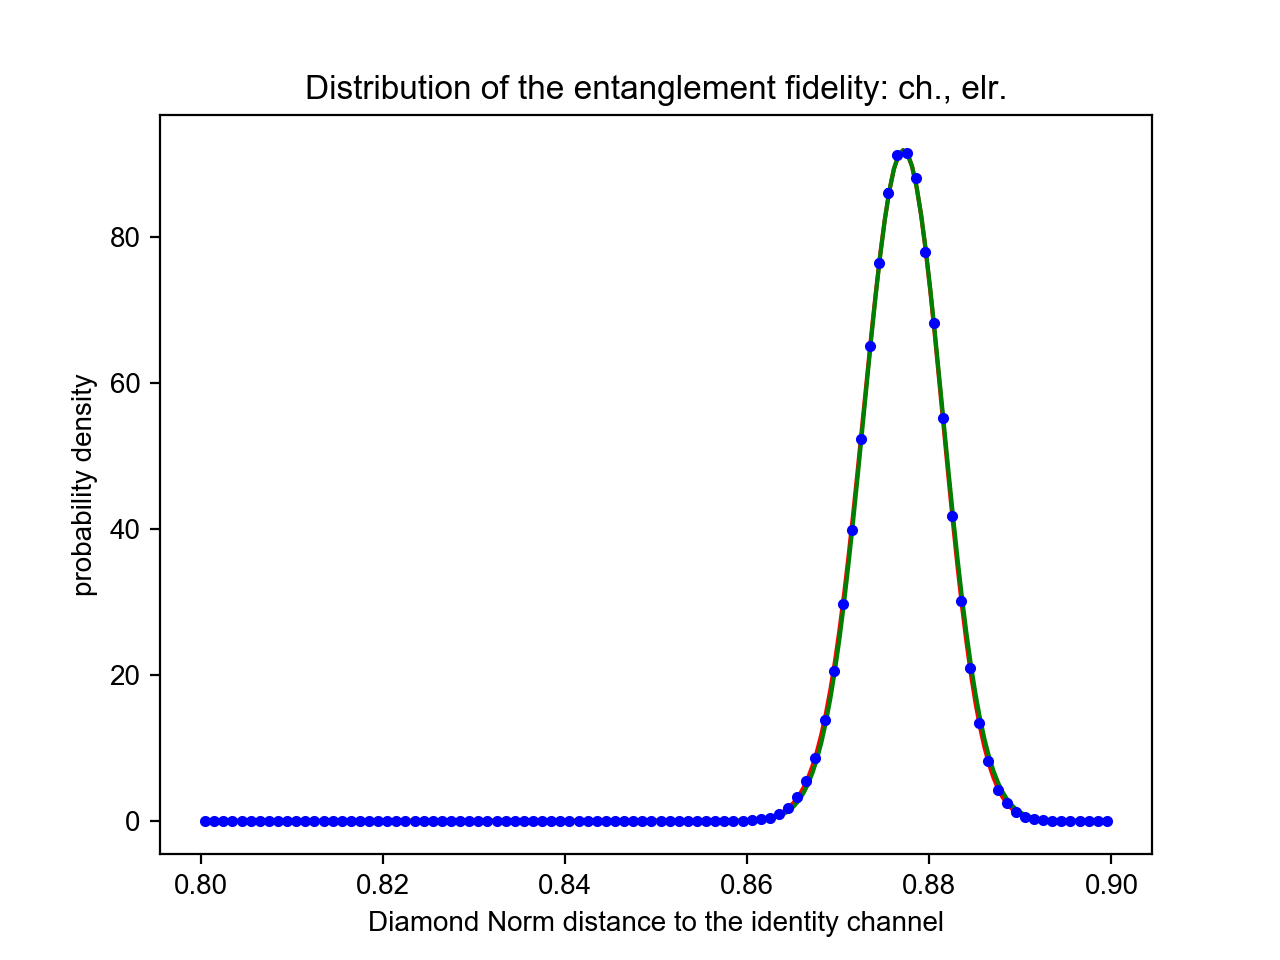

<IPython.core.display.Javascript object>


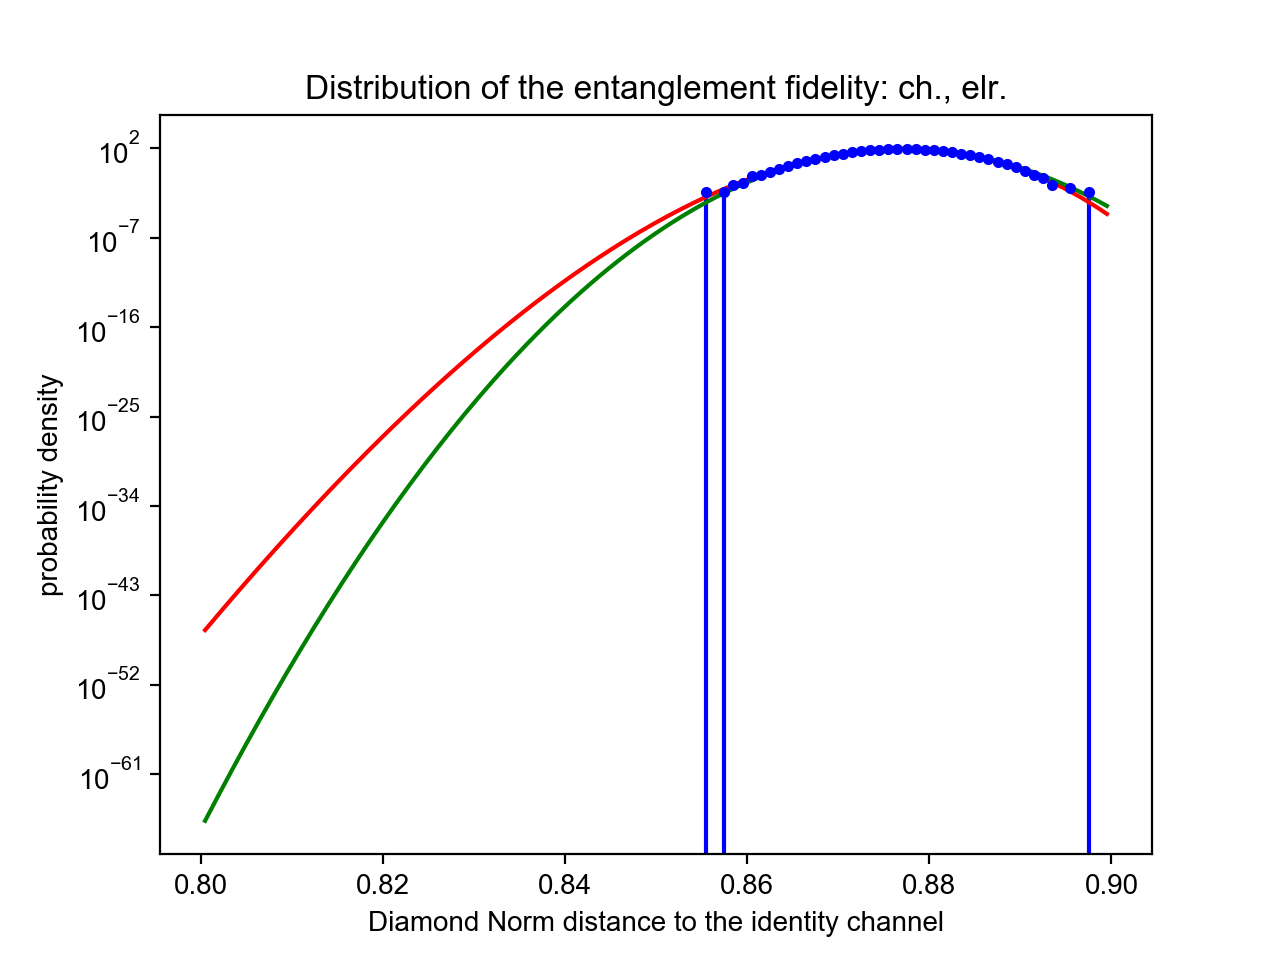

In [21]:
a_Fe_elr = do_analysis(r_Fe_elr, 'ch., elr.', plots=True,
                       qtyname='entanglement fidelity', ftox=(1,-1))

## Channel-space method, "elementary-rotation" variant, worst-case entanglement fidelity

In [22]:
r_wFe_elr = load_from_cache('r_wFe_elr')
if r_wFe_elr is None:
    # no stored result, perform computation
    with tomographer.jpyutil.RandWalkProgressBar() as prg:
        r_wFe_elr = dnormtomo.channelspace.run(
            dimX=4, dimY=4, Emn=Emn_for_channelspace, Nm=np.array(d.Nm),
            fig_of_merit='worst-entanglement-fidelity',
            hist_params=tomographer.UniformBinsHistogramParams(0.75, 0.9, 150),
            channel_walker_jump_mode=dnormtomo.channelspace.ElemRotations,
            mhrw_params=tomographer.MHRWParams(0.005, 500, 4096, 32768),
            progress_fn=prg.progress_fn,
            progress_interval_ms=2000,
            )
        prg.displayFinalInfo(r_wFe_elr['final_report_runs'])
    save_to_cache('r_wFe_elr', r_wFe_elr)
print_report(r_wFe_elr)

Loading `r_wFe_elr` from cache

Calculation ran for **2:16:15.379258 seconds**

```

                                        Final Report of Runs                                        
----------------------------------------------------------------------------------------------------
	step            : step_size=0.005
	# iter. / sweep = 500
	# therm. sweeps = 4096
	# run sweeps    = 32768
#0: 0.75|                       .........-+x%##%x+....     |0.9                [accept ratio = 0.30]
    error bars: 148 converged / 2 maybe (2 isolated) / 0 not converged
#1: 0.75|                   . .  ........-+x%##%o-....     |0.9                [accept ratio = 0.30]
    error bars: 146 converged / 3 maybe (3 isolated) / 1 not converged
#2: 0.75|                       .........-+x###%o+....     |0.9                [accept ratio = 0.29]
    error bars: 147 converged / 3 maybe (3 isolated) / 0 not converged
#3: 0.75|                        ........-+x%##%o-....     |0.9                [accept ratio = 0.30]
    error bars: 148 converged / 2 maybe (2 isolated) / 0 not converged
#4: 0.75|                        ........-+x%##%o+....     |0.9                [accept ratio = 0.30]
    error bars: 149 converged / 1 maybe (1 isolated) / 0 not converged
#5: 0.75|                        ........-+x%###o+.....    |0.9                [accept ratio = 0.30]
    error bars: 146 converged / 4 maybe (2 isolated) / 0 not converged
#6: 0.75|                       .........-+x%##%x+....     |0.9                [accept ratio = 0.30]
    error bars: 149 converged / 1 maybe (1 isolated) / 0 not converged
#7: 0.75|                      .  .......-+x%##%o+....     |0.9                [accept ratio = 0.30]
    error bars: 146 converged / 4 maybe (4 isolated) / 0 not converged
----------------------------------------------------------------------------------------------------


```

Fit parameters:
          a2 = 8.32677e-09
          a1 = 2635.16
           m = 367.677
           c = 1095.82
Quantum Error Bars:
          f0 = 0.8605
       Delta = 0.01029
       gamma = 0.000253



<IPython.core.display.Javascript object>


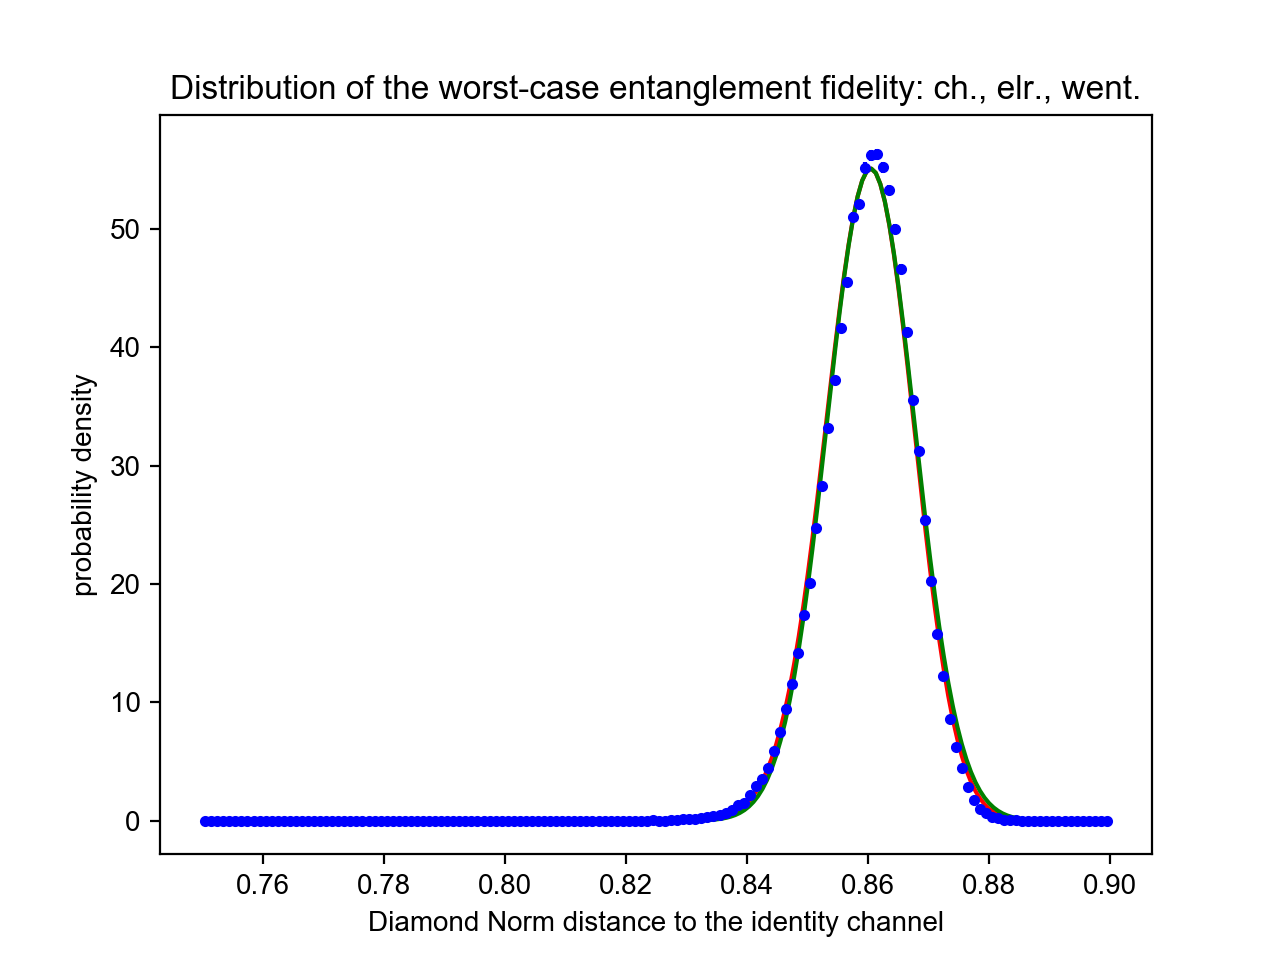

<IPython.core.display.Javascript object>


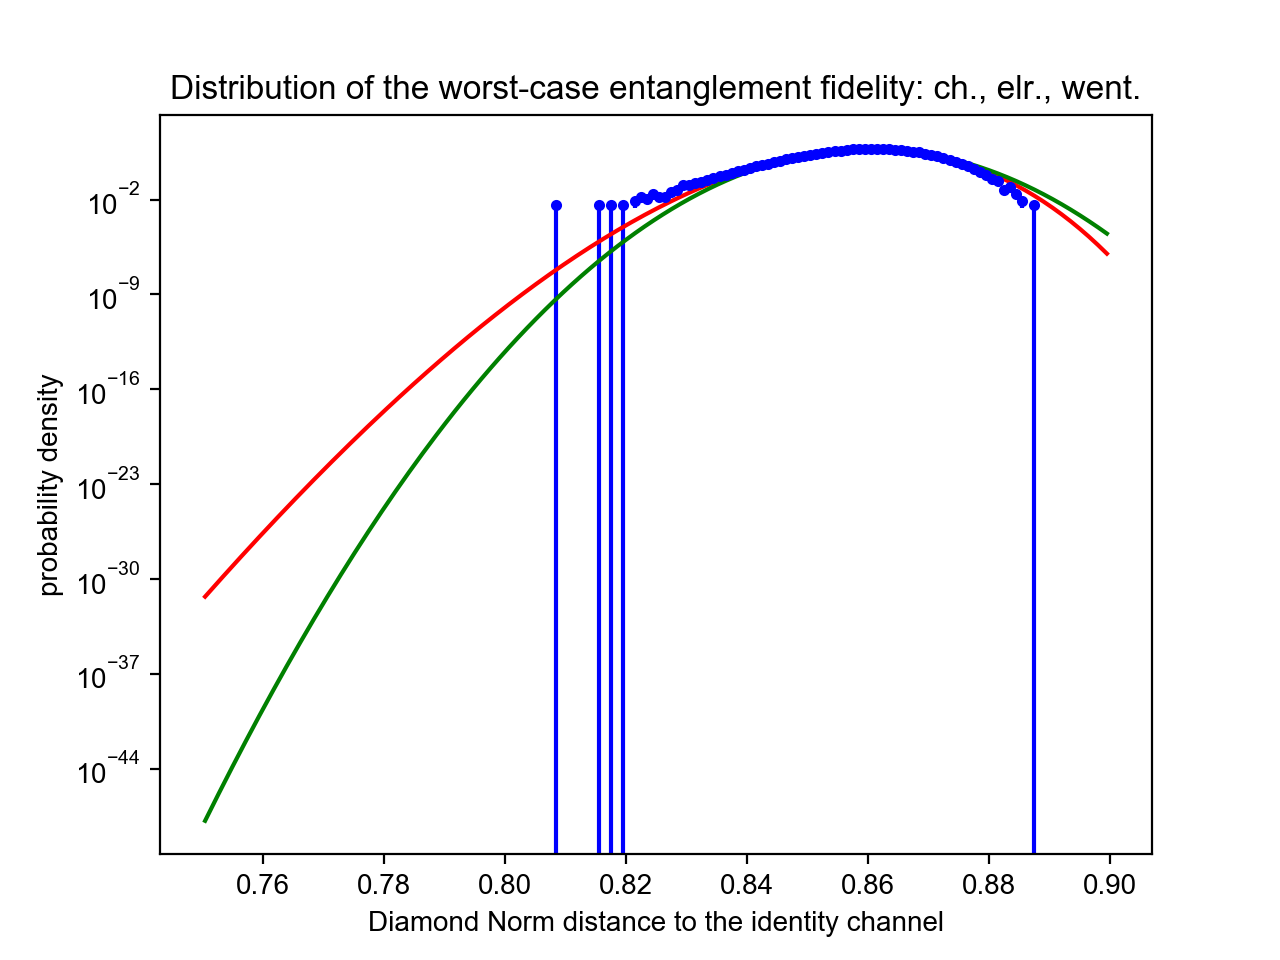

In [23]:
a_wFe_elr = do_analysis(r_wFe_elr, 'ch., elr., went.', plots=True,
                        qtyname='worst-case entanglement fidelity', ftox=(1,-1))

# Grand comparison plots

In [24]:
def do_comparison_plot(alist, fig=None, ax=None, log_scale=False, alt_analysis_args=None, xlabel='', flist=None):

    if fig is None:
        fig, ax = plt.subplots()
        
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel('probability density', fontsize=12)
    
    if log_scale:
        ax.set_yscale('log')
    
    clist = 'crbgmyk'
    
    class _Ns: pass
    thelabels = _Ns()
    thelabels.d = {}
    
    def add_label(s):
        k = len(thelabels.d)
        thelabels.d[k] = s
        return str(k)
    def last_label():
        return thelabels.d.get(len(thelabels.d)-1)
    
    qeb = dict()
    
    for i in range(len(alist)):
        a = alist[i]
        
        print("Taking care of plots for {}".format(a['name']))
        
        r = a['r']
        h = r['final_histogram'].normalized()
        c = clist[i%len(clist)]
        f = h.values_center
        #analysis = a['analysis']
        
        analysis_dflt = tomographer.querrorbars.HistogramAnalysis(h)
        analysis_dflt.printFitParameters()
        qeb[a['name']] = analysis_dflt.printQuantumErrorBars()
        
        analysis = None
        if alt_analysis_args:
            analysis = tomographer.querrorbars.HistogramAnalysis(h, **alt_analysis_args)
            analysis.printFitParameters()
        
        if log_scale:
            ax.errorbar(x=f, y=h.bins, yerr=h.delta, c=c, fmt='.', label=last_label())
        else:
            ax.errorbar(x=f, y=h.bins, yerr=h.delta, c=c, fmt='.', label=add_label('{}, his.'.format(a['name'])))
        
        if flist is None:
            theflist = np.linspace(np.min(f), np.max(f), 100)
        else:
            theflist = flist
        
        plist_dflt = np.exp(analysis_dflt.fit_fn(analysis_dflt.ftox(theflist), *analysis_dflt.fit_params))
        if log_scale:
            ax.plot(theflist, plist_dflt, c=c, ls=':', label=last_label())
        else:
            ax.plot(theflist, plist_dflt, c=c, ls=':', label=add_label('{}, fit1'.format(a['name'])))
        
        
        if analysis is not None:
            plist = np.exp(analysis.fit_fn(analysis.ftox(theflist), *analysis.fit_params))
            if log_scale:
                ax.plot(theflist, plist, c=c, label=last_label())
            else:
                ax.plot(theflist, plist, c=c, label=add_label('{}, fit2'.format(a['name'])))
    
    
    handles, labels = ax.get_legend_handles_labels()
    iorder = sorted(range(len(handles)), key=lambda i: int(labels[i]))
    
    ax.legend([handles[i] for i in iorder], [thelabels.d[int(labels[i])] for i in iorder],fontsize=11)
    
    return dict(qeb=qeb, fig=fig, ax=ax)

### Diamond norm analysis

<IPython.core.display.Javascript object>


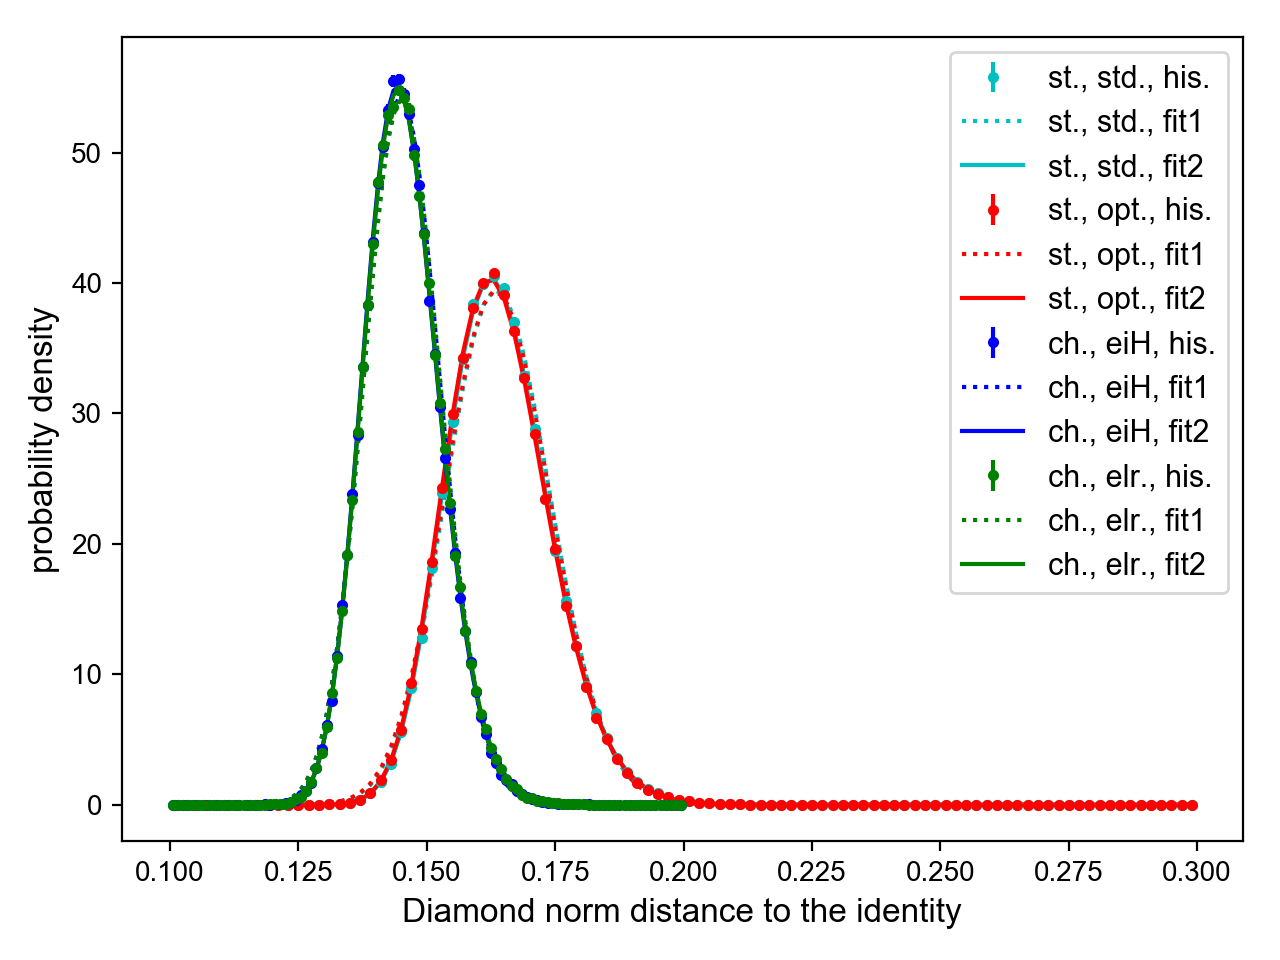

Taking care of plots for st., std.
Fit parameters:
          a2 = 3.68652e-07
          a1 = 1591.46
           m = 260.276
           c = 735.226
Quantum Error Bars:
          f0 = 0.1635
       Delta = 0.01434
       gamma = 0.0004189



Fit parameters:
           a = 11.7617
          xq = -13.5556
           m = 11.7945
           p = 8.68157
           c = 2228.03
Taking care of plots for st., opt.
Fit parameters:
          a2 = 4.40892e-16
          a1 = 1570.24
           m = 256.601
           c = 725.098
Quantum Error Bars:
          f0 = 0.1634
       Delta = 0.01443
       gamma = 0.0004246



Fit parameters:
           a = 9.79934
          xq = -15.9191
           m = 11.2089
           p = 8.88433
           c = 2548.39
Taking care of plots for ch., eiH
Fit parameters:
          a2 = 1.60136e-13
          a1 = 2666.08
           m = 386.433
           c = 1136.79
Quantum Error Bars:
          f0 = 0.1449
       Delta = 0.01043
       gamma = 0.0002501



Fit parameters:
           a = 35.0895
          xq = -7.55392
           m = 10.2541
           p = 8.98891
           c = 2100.29
Taking care of plots for ch., elr.
Fit parameters:
          a2 = 1.16189e-07
          a1 = 2642.59
           m = 383.192
           c = 1127.12
Quantum Error Bars:
          f0 = 0.145
       Delta = 0.01048
       gamma = 0.0002523

Fit parameters:
           a = 33.912
          xq = -7.6871
           m = 9.98913
           p = 9.05551
           c = 2100.27


In [25]:
def fit_fn_q_lnxp_dnorm(x, a, xq, m, p, c):
    return -a*np.square(x-xq) - m*np.power(-np.log(x)/-np.log(0.16), p) + c

xyz = do_comparison_plot([a_naive, a_naiveopt, a_eiH, a_elr],
                         alt_analysis_args=dict(fit_fn=fit_fn_q_lnxp_dnorm, maxfev=10000,
                                                bounds=((0,-np.inf,0,0,-np.inf),np.inf),
                                                p0=(12, -13, 0.057, 8.8, 2100),),
                         xlabel='Diamond norm distance to the identity')
fig = xyz['fig']
fig.tight_layout()
fig.savefig('twoqubits.pdf', format='pdf')
plt.show()

### Entanglement fidelity & worst-case entanglement fidelity analysis

<IPython.core.display.Javascript object>


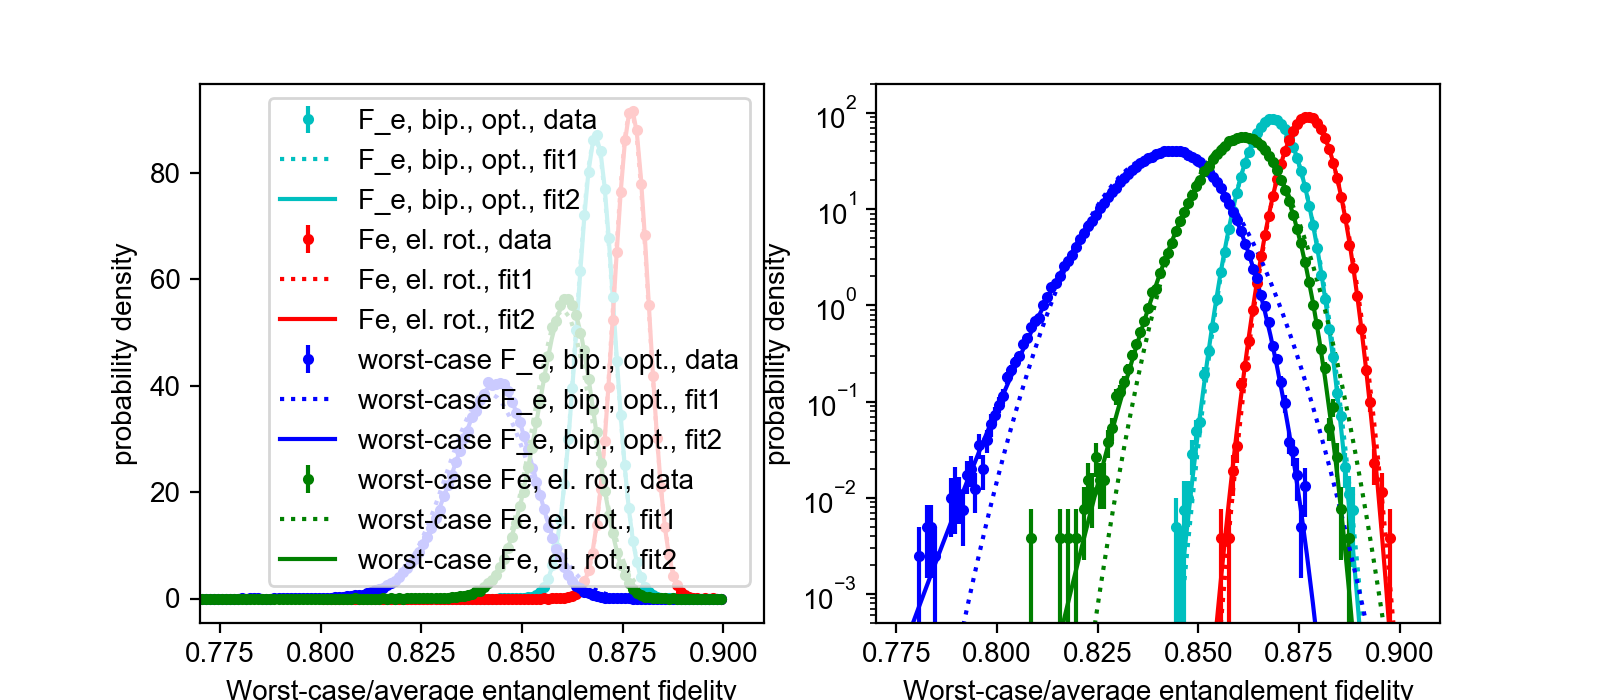

Taking care of plots for F_e, bip., opt.
Fit parameters:
          a2 = 23538.7
          a1 = -40871.5
           m = 0.253233
           c = -17737.4
Quantum Error Bars:
          f0 = 0.8682
       Delta = 0.006518
       gamma = 1.164e-10



Fit parameters:
           a = 5237.39
          xq = -0.50837
           m = 3739.94
           p = 0.433076
           c = 6283.22
Taking care of plots for Fe, el. rot.
Fit parameters:
          a2 = 26384.3
          a1 = -46204.9
           m = 64.2781
           c = -20215.8
Quantum Error Bars:
          f0 = 0.877
       Delta = 0.006152
       gamma = 2.274e-08



Fit parameters:
           a = 2704.83
          xq = -0.689159
           m = 426.151
           p = 1.69552
           c = 2455.32
Taking care of plots for worst-case F_e, bip., opt.
Fit parameters:
          a2 = 4505.68
          a1 = -7584.89
           m = 2.3125e-10
           c = -3188.46
Quantum Error Bars:
          f0 = 0.8417
       Delta = 0.0149
       gamma = 3.184e-18



Fit parameters:
           a = 10.758
          xq = -13.6491
           m = 2.45227
           p = 9.34316
           c = 2063.35
Taking care of plots for worst-case Fe, el. rot.
Fit parameters:
          a2 = 9041.54
          a1 = -15553.6
           m = 0.10872
           c = -6685
Quantum Error Bars:
          f0 = 0.8601
       Delta = 0.01052
       gamma = 3.483e-10



Fit parameters:
           a = 29.2336
          xq = -8.20665
           m = 1.58379
           p = 10.287
           c = 2053.04


In [28]:
def fit_fn_q_lnxp_Fe(x, a, xq, m, p, c):
    return -a*np.square(x-xq) - m*np.power(-np.log(x)/-np.log(0.2), p) + c

xyz = do_comparison_plot([a_Fe_naiveopt, a_Fe_elr, a_wFe_naiveopt, a_wFe_elr],
                         alt_analysis_args=dict(fit_fn=fit_fn_q_lnxp_Fe, maxfev=1000000, ftox=(1,-1),
                                                bounds=((0,-np.inf,0,0,-np.inf),np.inf),
                                               ),
                         xlabel='Worst-case/average entanglement fidelity')

fig, ax1, ax2 = xyz['fig'], xyz['ax1'], xyz['ax2']

ax1.set_xlim([0.77, 0.91])
ax2.set_xlim([0.77, 0.91])
ax2.set_ylim([5e-4, 2e2])
    

xyz['fig'].savefig('comparison_plot_Fe_wFe.pdf', format='pdf')
plt.show()

## behavior of $\mu(f)$ for larger values of f.

Note: We need to evaluate everything in log space or we get overflows.

Fit parameters:
          a2 = 26384.3
          a1 = -46204.9
           m = 64.2781
           c = -20215.8
Quantum Error Bars:
          f0 = 0.877
       Delta = 0.006152
       gamma = 2.274e-08



<IPython.core.display.Javascript object>


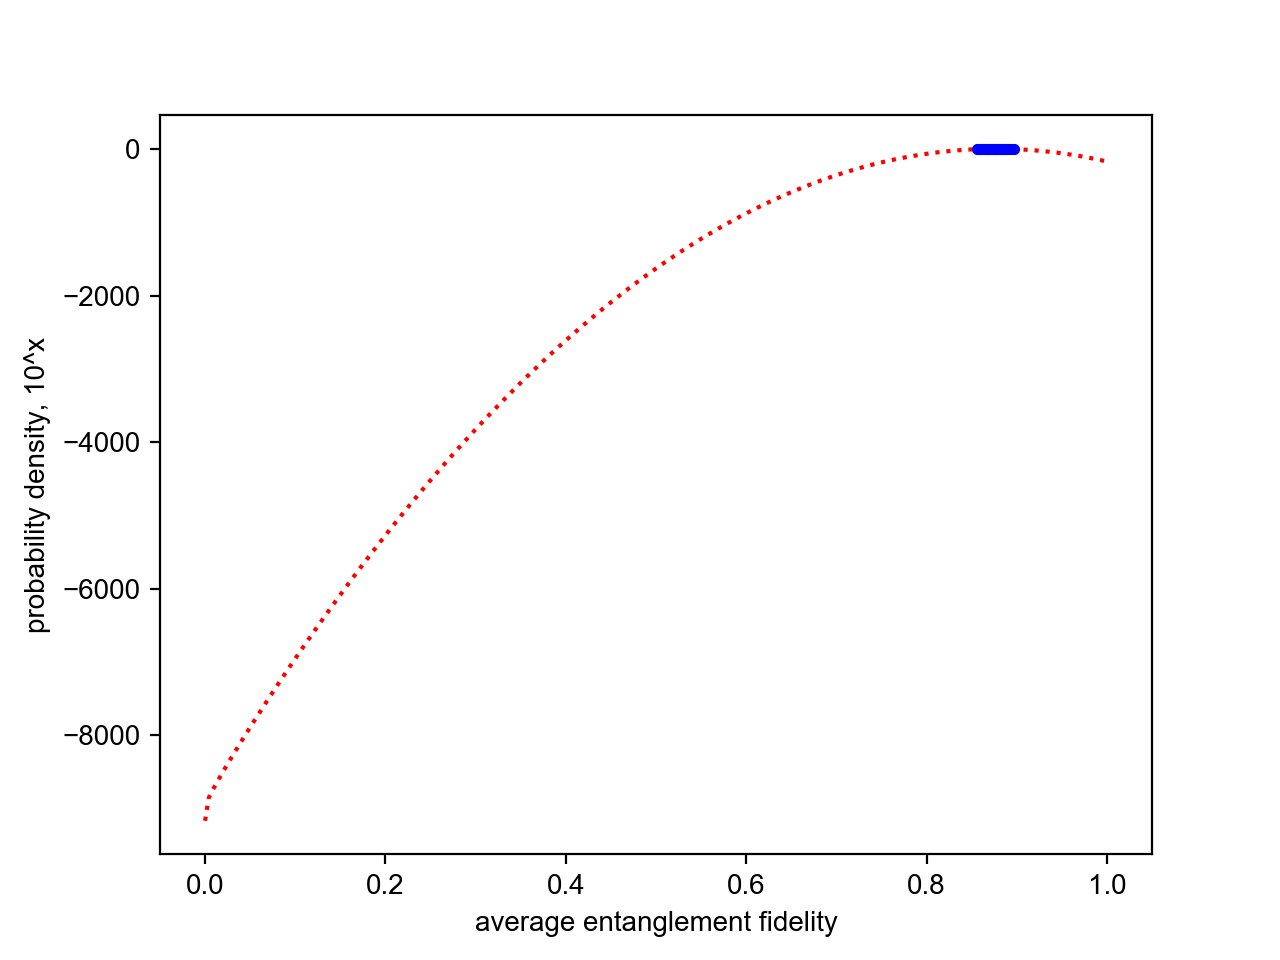

In [29]:
# normalized histogram
hn = r_Fe_elr['final_histogram'].normalized()

analysis_dflt_elr = tomographer.querrorbars.HistogramAnalysis(hn)
analysis_dflt_elr.printFitParameters()
analysis_dflt_elr.printQuantumErrorBars()
        
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_xlabel('average entanglement fidelity')
ax.set_ylabel('probability density, 10^x')

f = hn.values_center

# careful between log10() and ln()=log()
idx = np.nonzero(hn.bins)
ax.errorbar(x=f[idx], y=np.log10(hn.bins[idx]),
            yerr=np.divide(hn.delta[idx], hn.bins[idx])/np.log(10), c='b', fmt='.')

theflist = np.linspace(1e-6, 1, 256)
y1 = analysis_dflt_elr.fit_fn(analysis_dflt_elr.ftox(theflist),
                              *analysis_dflt_elr.fit_params)/np.log(10.0)
ax.plot(theflist, y1, c='r', ls=':')

plt.show()